In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['lanl_earthquake_mels', 'LANL-Earthquake-Prediction']


In [2]:
DATA = Path('../input/LANL-Earthquake-Prediction')
PREPROCESSED = Path('../input/lanl_earthquake_mels')
WORK = Path('work')
Path(WORK).mkdir(exist_ok=True, parents=True)

ALL_X_TRAIN = str(PREPROCESSED/'X_train_all.npy')
ALL_X_TEST = str(PREPROCESSED/'X_test_all.npy')
CSV_TRAIN = str(PREPROCESSED/'train_data.csv')
CSV_SUBMISSION = DATA/'sample_submission.csv'

TEST_FILES = sorted(list((DATA/'test').glob('*.csv')))
N_TESTS = len(TEST_FILES)

TEST_LEN = 150_000
TRAIN_LEN = 629_145_480
Fs = 4_000_000

IMG_DIM = 128
MELS_LEN  = 40000
MELS_STEP = MELS_LEN // 34 # to make it IMG_DIM squared

SEGMENT_DIV  = 15
SEGMENT_LEN  = TEST_LEN
SEGMENT_STEP = SEGMENT_LEN // SEGMENT_DIV
TRAIN_SEGS = (TRAIN_LEN // SEGMENT_STEP) - SEGMENT_DIV + 1

In [3]:
import gc
import os
import time
import logging
import datetime
import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

def load_pkl(filename):
    """Load pickle object from file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
X_train = load_pkl(ALL_X_TRAIN)
X_test = load_pkl(ALL_X_TEST)
df = pd.read_csv(CSV_TRAIN)
df.head()

,seg,ttf,valid
0,0,1.430797,True
1,1,1.427600,True
2,2,1.425498,True
3,3,1.423396,True
4,4,1.420198,True


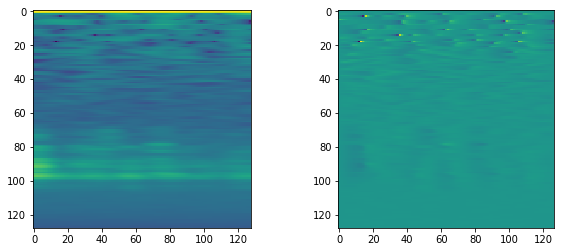

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, plotee in zip(axes.flat, [X_train[0], np.diff(X_train[0], axis=-1)]):
    ax.imshow(plotee)

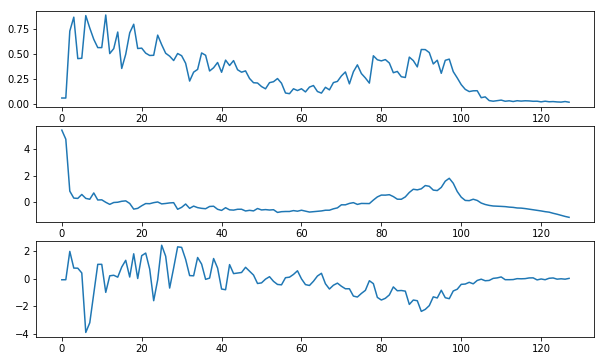

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10,6))
for ax, plotee in zip(axes.flat,
              [X_train[0].std(axis=-1),  # Variance
               X_train[0].mean(axis=-1), # Mean
               np.diff(X_train[0], axis=-1).sum(axis=-1) # Naive Trend --> Useless...
              ]):
    ax.plot(plotee)

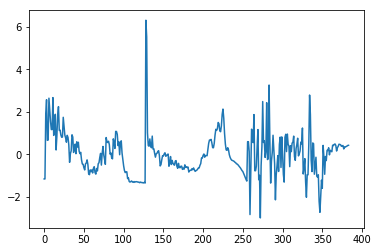

In [9]:
def trend(x):
    half = x.shape[1] // 2
    # 1. NG: Naive trend # np.diff(X2d, axis=-1).sum(axis=-1)
    # 2. NG: Simple trend
    #   t0 = x[:, :half].mean(axis=-1)
    #   t1 = x[:, half:].mean(axis=-1)
    # 3. Variance trend
    t0 = x[:, :half].std(axis=-1)
    t1 = x[:, half:].std(axis=-1)
    return t1 - t0
def standardize(x):
    x -= x.mean()
    x /= x.std() + 1e-6
    return x
def fft_raw_to_3features(X2d):
    x = np.r_[standardize(X2d.std(axis=-1)),  # Variance
              standardize(X2d.mean(axis=-1)), # Mean
              standardize(trend(X2d))         # Trend
             ]
    return x

plt.plot(fft_raw_to_3features(X_train[0]))

In [10]:
print(f'Before {X_train.shape} {X_test.shape}')
X_train = np.array([fft_raw_to_3features(x) for x in X_train])
X_test = np.array([fft_raw_to_3features(x) for x in X_test])
print(f'After {X_train.shape} {X_test.shape}')

Before (62900, 128, 128) (2624, 128, 128)
After (62900, 384) (2624, 384)


In [11]:
Xdf = pd.DataFrame(X_train, columns=[f'v{x:d}' for x in range(128)]
                   + [f'm{x:d}' for x in range(128)] + [f't{x:d}' for x in range(128)])
ydf = pd.DataFrame(df.ttf)
np.abs(Xdf.corrwith(ydf.ttf)).sort_values(ascending=False).head(20)

m0      0.608917
m1      0.607162
m99     0.576367
m80     0.567259
m94     0.562702
m100    0.559261
m109    0.555354
m108    0.551122
m110    0.550081
m111    0.549778
m91     0.549773
m79     0.547509
m95     0.546798
m81     0.546140
m112    0.545782
m90     0.544174
m87     0.543478
m96     0.542784
m71     0.540394
m86     0.538768
dtype: float64

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train = df.ttf.values

In [13]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

def train_model(X=X_train_scaled, X_test=X_test_scaled, X_columns=Xdf.columns, y=y_train, params=None,
                folds=folds, model_type='lgb', plot_feature_importance=False, model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        Xtrn, Xval = X[train_index], X[valid_index]
        ytrn, yval = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            #model = lgb.LGBMRegressor(num_leaves=31,
            #            learning_rate=0.05,
            #            n_estimators=20)
            model = lgb.LGBMRegressor(**params,
                                      n_jobs = -1)
            model.fit(Xtrn, ytrn, 
                    eval_set=[(Xtrn, ytrn), (Xval, yval)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(Xval)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=Xtrn, label=ytrn, feature_names=X_columns)
            valid_data = xgb.DMatrix(data=Xval, label=yval, feature_names=X_columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist,
                              early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(Xval, feature_names=X_columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(Xtrn, ytrn)
            
            y_pred_valid = model.predict(Xval).reshape(-1,)
            score = mean_absolute_error(yval, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(Xtrn, ytrn, eval_set=(Xval, yval), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(Xval)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(yval, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction
    
#train_model()

In [16]:
from collections import Counter
import random

def balance_class_by_limited_over_sampling(X, y, max_sample_per_class=None, multiply_limit=2., random_state=42):
    """Balance class distribution basically by oversampling but limited duplication.

    # Arguments
        X: Data samples, only size of samples is used here.
        y: Class labels to be balanced.
        max_sample_per_class: Number of maximum samples per class, large class will be limitd to this number.
        multiply_limit: Small size class samples will be duplicated, but limited to multiple of this number.
    """
    assert len(X) == len(y), f'Length of X({len(X)}) and y({len(y)}) are supposed to be the same.'
    y_count = Counter(y)
    max_sample_per_class = max_sample_per_class or np.max(list(y_count.values()))
    resampled_idxes = []
    random.seed(random_state)
    for cur_y, count in y_count.items():
        this_samples = np.min([multiply_limit * count, max_sample_per_class]).astype(int)
        idxes = np.where(y == cur_y)[0]
        idxes = random.choices(idxes, k=this_samples)
        resampled_idxes += list(idxes)
    return X[resampled_idxes], y[resampled_idxes]

def df_balance_class_by_limited_over_sampling(df, label_column,
                                              max_sample_per_class=None, multiply_limit=2.,
                                              random_state=42):
    """Balance class distribution in DataFrame with balance_class_by_limited_over_sampling."""
    X, y = list(range(len(df))), list(df[label_column])
    X, _ = balance_class_by_limited_over_sampling(X, y, max_sample_per_class=max_sample_per_class,
                                                  multiply_limit=multiply_limit, random_state=random_state)
    return df.iloc[X].sort_index()

def digitize(y): return np.array(list(map(lambda x: int(x*10), y)))
def balance_train_data3(X, y, random_state=42):
    X_index = np.array(range(len(X)))
    y_as_label = digitize(y)
    X_resampled_index, _ = balance_class_by_limited_over_sampling(X_index, y_as_label, multiply_limit=100.)
    X_resampled_index = sorted(X_resampled_index)
    return X[X_resampled_index], y[X_resampled_index]
X_train_scaled3, y_train3 = balance_train_data3(X_train_scaled, y_train)

Fold 0 started at Sat Apr 13 06:11:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1.47305	valid_1's l1: 1.58429
Fold 1 started at Sat Apr 13 06:16:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1.4715	valid_1's l1: 1.60932
Fold 2 started at Sat Apr 13 06:21:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1.47325	valid_1's l1: 1.58126
Fold 3 started at Sat Apr 13 06:27:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1.47512	valid_1's l1: 1.59883
Fold 4 started at Sat Apr 13 06:32:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 1

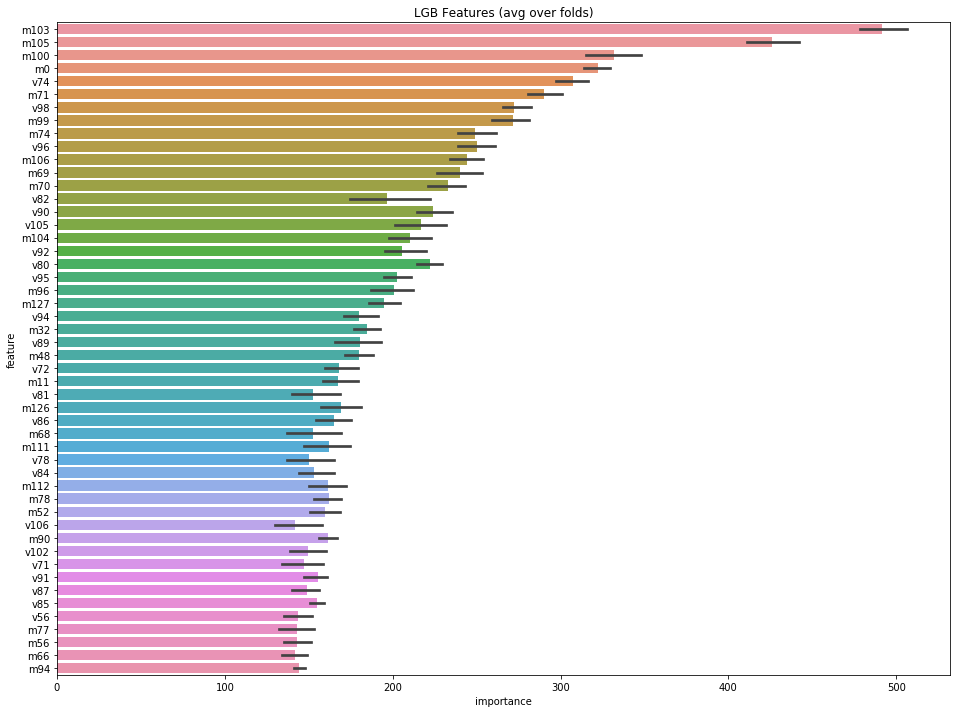

In [19]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'n_estimators': 3000,
         }
oof_lgb3, prediction_lgb3, feature_importance3 = train_model(X=X_train_scaled3, y=y_train3,
                                                             params=params, model_type='lgb', plot_feature_importance=True)

Text(0.5, 1.0, 'lgb')

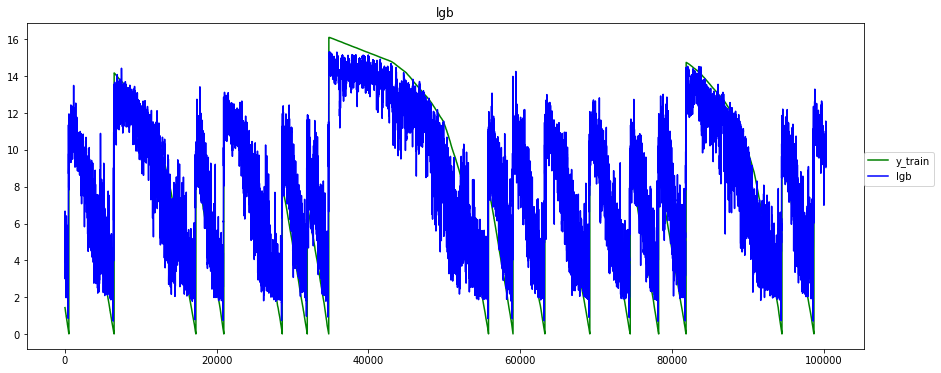

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(y_train3, color='g', label='y_train')
plt.plot(oof_lgb3, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb')

In [ ]:
submission = pd.read_csv(DATA/'sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb3
print(submission.head())
submission.to_csv('submission.csv')